### Prueba técnica - Itinerario Data Science con python.

# Notebook 4. Predicción de la serie temporal con la librería Prophet. 



En este notebook voy a explorar la serie temporal y ha hacer una predicción con la librería Prophet.

In [2]:
## Librerías

# Data wrangling
#-----------------------------------------------------------------------
import numpy as np
import pandas as pd


## Time series
##----------------------------------------------------------------
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

## Visualización de datos
##----------------------------------------------------------------
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns


# MySQL conection
#-----------------------------------------------------------------------
import mysql.connector




In [3]:
# Seaborn settings
sns.set_style("darkgrid")
sns.set_palette('RdGy')

## 1. Preparación del dataset.

En primer lugar voy a cargar los datos de la base de datos MySQL y los introduciré en un dataframe, para a continuación darle formato y preprocesar el dataset. 

### 1.1. Carga de los datos.

Cargamos los datos con la ayuda de la librería mysql.connector.

In [4]:
# Conection with localhost 
mydb = mysql.connector.connect(
  host='localhost',
  user='root',
  password='c4nionerou', 
  database='bcn_precipitaciones'
)

In [5]:
# Opnening a cursor
mycursor = mydb.cursor(dictionary=True)

In [6]:
# Query for extracting
query2 = '''SELECT * 
           FROM precipitaciones'''

In [7]:
mycursor.execute(query2)

In [8]:
DATA_b = mycursor.fetchall()
#DATA_b

In [9]:
DATA = pd.DataFrame(DATA_b)

In [10]:
mycursor.close()

True

In [11]:
mydb.commit()

### 1.2. Preprocesamiento del dataset.

Antes de trabajar con la serie temporal tenemos que seguir los siguientes pasos:
1. Dar formato correspondiente a cada campo.
2. Búsqueda de duplicados.
3. Tratamiento de valores perdidos.
4. Introducir fecha en el indice y hacer un resample por mes.


In [12]:
# First lines
DATA.head(3)

,ID,fecha,precipitacion,horas_sol,presion_max,presion_min,temperatura_min,temperatura_max,velocidad_media
0,0,1992-01-01,0.0,6.6,1037.8,1033.6,11.6,0.3,7.92
1,1,1992-01-02,0.0,6.4,1038.6,1037.0,12.6,0.2,11.16
2,2,1992-01-03,0.3,1.0,1037.3,1032.7,12.2,2.3,7.92


In [13]:
# General info 
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10775 entries, 0 to 10774
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               10775 non-null  int64 
 1   fecha            10775 non-null  object
 2   precipitacion    10775 non-null  object
 3   horas_sol        10775 non-null  object
 4   presion_max      10775 non-null  object
 5   presion_min      10775 non-null  object
 6   temperatura_min  10775 non-null  object
 7   temperatura_max  10775 non-null  object
 8   velocidad_media  10775 non-null  object
dtypes: int64(1), object(8)
memory usage: 757.7+ KB


In [14]:
# fecha to datetime
DATA.fecha = pd.to_datetime(DATA.fecha,format='%Y-%m-%d' )

In [15]:
columnas = DATA.columns
# columns to numeric
for campo in columnas[2:]:
    DATA[campo] = pd.to_numeric(DATA[campo])

In [16]:
# General info after formating features
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10775 entries, 0 to 10774
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               10775 non-null  int64         
 1   fecha            10775 non-null  datetime64[ns]
 2   precipitacion    10693 non-null  float64       
 3   horas_sol        10285 non-null  float64       
 4   presion_max      10719 non-null  float64       
 5   presion_min      10718 non-null  float64       
 6   temperatura_min  10743 non-null  float64       
 7   temperatura_max  10743 non-null  float64       
 8   velocidad_media  10775 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 757.7 KB


In [17]:
# Duplicated rows
DATA[DATA.duplicated()].sum()

ID                 0.0
precipitacion      0.0
horas_sol          0.0
presion_max        0.0
presion_min        0.0
temperatura_min    0.0
temperatura_max    0.0
velocidad_media    0.0
dtype: float64

In [19]:
# Total percentage missing values 
(DATA.isna().sum()/DATA.shape[0]*100).round(2)

ID                 0.00
fecha              0.00
precipitacion      0.76
horas_sol          4.55
presion_max        0.52
presion_min        0.53
temperatura_min    0.30
temperatura_max    0.30
velocidad_media    0.00
dtype: float64

El porcentage de valores perdidos es en general inferior al 1% salvo en la variable horas de sol. Para tratar los valores perdidos voy a utilizar el siguiente enfoque:
- __precipitación__: como se trata de la variable objetivo y tenemos menos de un 1%, estos valores perdidos los voy a eliminar.

- __Resto de variables__: En este caso voy a interpolar los valores nulos, entender que el valor diario estará muy cerca del promedio de los días anterior y posterior.




In [20]:
# Dropping Missing values for target precipitacion
DATA.dropna(axis=0,
            subset=['precipitacion'], 
            inplace=True)

In [21]:
# Interpolating missing values for the other features
DATA.interpolate(inplace=True)

### 1.3. Formatear la serie temporal.

In [22]:
# fecha to index
DATA.set_index('fecha', drop=True, inplace=True)

In [24]:
# Dropping ID, mes and anio
DATA.drop(columns=['ID',], inplace=True)

In [26]:
# Lluvia 
DATA['lluvia'] = 0
DATA.loc[DATA.precipitacion > 0, 'lluvia'] = 1

In [27]:
ST_MES = DATA.resample('M').agg({'precipitacion':'sum',
                                 'horas_sol': 'mean',
                                 'presion_max': 'mean',
                                 'presion_min': 'mean',
                                 'temperatura_min':'mean',
                                 'temperatura_max':'mean',
                                 'velocidad_media':'mean',
                                 'lluvia':'sum'
                                 })

In [28]:
ST_MES

,precipitacion,horas_sol,presion_max,presion_min,temperatura_min,temperatura_max,velocidad_media,lluvia
fecha,,,,,,,,
1992-01-31,64.5,4.387097,1026.948387,1023.058065,11.648387,2.398387,14.365161,7
1992-02-29,9.4,4.931034,1026.865517,1023.206897,13.286207,3.603448,12.364138,3
1992-03-31,22.4,5.532258,1020.425806,1015.035484,15.422581,6.048387,14.074839,6
1992-04-30,20.8,8.996667,1015.080000,1010.283333,17.636667,7.660000,14.916000,6
1992-05-31,63.8,7.990323,1017.519355,1014.090323,20.616129,13.000000,12.402581,9
...,...,...,...,...,...,...,...,...
2021-03-31,10.3,6.316129,1024.167742,1019.483871,15.835484,8.700000,15.201290,3
2021-04-30,33.3,5.955000,1018.156667,1013.570000,17.446667,10.353333,16.380000,6
2021-05-31,14.2,8.048387,1018.774194,1013.351613,21.200000,14.480645,17.883871,7


In [29]:
# Dropping last row, july 2021
ST_MES = ST_MES[0:-1]

# 2. Predicción de valores con la librería prophet.

En el notebook 2 hicimos una descompposición de la serie temporal, veamos como quedaba:

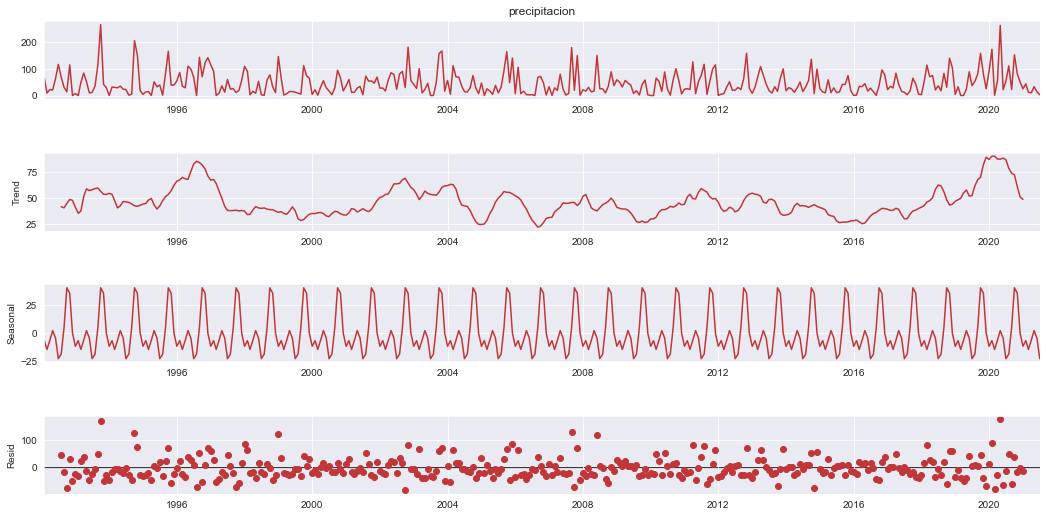

In [30]:
decomposed_ts=seasonal_decompose(ST_MES.precipitacion, model='additive', period=12)
fig=decomposed_ts.plot()
fig.set_figheight(8)
fig.set_figwidth(16);

Para trabajar con Prophet tenemos que preparar un dataframe con dos columnas llamadas ds e y. 
- ds son los datos de tiempo que tienen que estar en formato datetime.
- y es la variable objetivo, en nuestro caso precipitación.

In [35]:
# Setting df.
df = ST_MES[['precipitacion']].reset_index()
df.columns = ['ds','y']

A continuación para hacer una predicción tenemos que obtener el df, en este caso escojeré los últimos 10 años y apartaremos los últimos 6 meses.

df_pred es un df con los datos de ds completos.

In [208]:
# Setting df for last 10 years. 
df_train=df.iloc[-120:-6]
df_pred=df[['ds']].iloc[-120:]

In [209]:
# Fitting a Prophet model
model = Prophet(growth='linear',
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False,
                seasonality_mode='additive',
                changepoint_prior_scale = 5,
                changepoints = ['2012-02-01','2013-01-01','2014-01-01','2016-01-01','2017-01-01',
                                '2017-11-01', '2018-03-01','2019-01-01','2020-02-01',]
               )
model.fit(df_train)

forecast = model.predict(df_pred)

In [210]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
115,2021-02-28,58.922041,-6.510466,78.694228,58.922041,58.922041,-23.279824,-23.279824,-23.279824,-23.279824,-23.279824,-23.279824,0.0,0.0,0.0,35.642217
116,2021-03-31,55.603068,7.191709,95.323833,55.384980,55.611690,-2.123788,-2.123788,-2.123788,-2.123788,-2.123788,-2.123788,0.0,0.0,0.0,53.479280
117,2021-04-30,52.391159,33.447789,123.317496,49.593917,55.006268,24.663548,24.663548,24.663548,24.663548,24.663548,24.663548,0.0,0.0,0.0,77.054707
118,2021-05-31,49.072185,-19.632304,69.950263,43.440706,55.396761,-24.434620,-24.434620,-24.434620,-24.434620,-24.434620,-24.434620,0.0,0.0,0.0,24.637566
119,2021-06-30,45.860276,-26.029684,64.949924,37.216006,56.034341,-26.425170,-26.425170,-26.425170,-26.425170,-26.425170,-26.425170,0.0,0.0,0.0,19.435106


<AxesSubplot:title={'center':'Actual vs Forecast'}, xlabel='ds'>

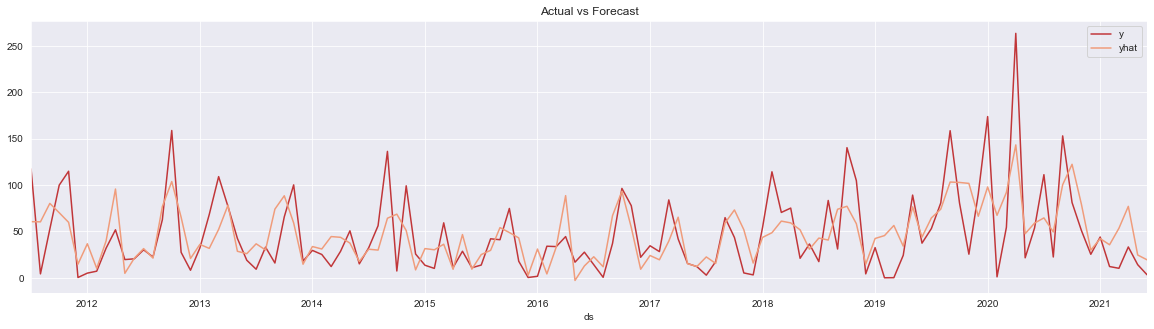

In [211]:
ax = (df.iloc[-120:].plot(x='ds',
                          y='y',
                          figsize=(20,5),
                          title='Actual Vs Forecast'))

forecast.plot(x='ds',
              y='yhat',
              figsize=(20,5),
              title='Actual vs Forecast', 
              ax=ax)

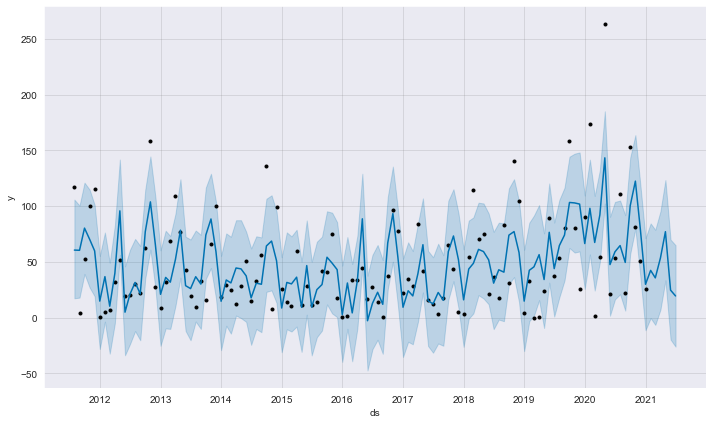

In [212]:
# Plotting the generated forecast
fig1 = model.plot(forecast, uncertainty=True)

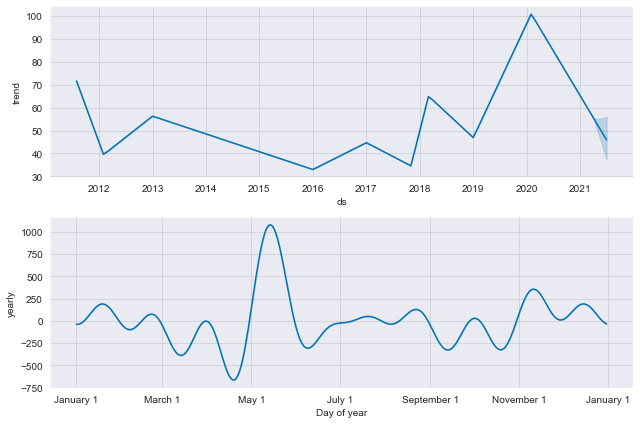

In [213]:
# Plotting the forecast components.
fig2 = model.plot_components(forecast)

Hemos configurado el modelo de serie temporal con prophet y se observa como predice unos valores ligeramente superiores para los últimos datos de la serie temporal. 